In [1428]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [1429]:
def resize_image (img, new_width=256, new_height=256):
    height, width = img.shape[:2]
    
    scale_x = width / new_width
    scale_y = height / new_height
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    
    for i in range(new_height):
        for j in range(new_width):
            orig_x = int(j * scale_x)
            orig_y = int(i * scale_y)
            resized_img[i, j] = img[orig_y, orig_x]  
    return resized_img

In [1430]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img)
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [1431]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


Rosacea


100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [1432]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [1433]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [1434]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    kernel = np.zeros((size, size), dtype=np.float64)

    for i in range(size):
        for j in range(size):
            x = ax[j]  
            y = ax[i]  
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2. * sigma**2))

    return kernel / np.sum(kernel)

def konvolusi(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    output = np.zeros_like(image, dtype=np.float64)

    for i in range(img_h):
        for j in range(img_w):
            region = padded_image[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

def gaussian_blur(image: np.ndarray, kernel_size: int = 3, sigma: float = 0.0) -> np.ndarray:
    if sigma == 0.0:
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8

    kernel = gaussian_kernel(kernel_size, sigma)
    blurred = konvolusi(image, kernel)
    return blurred


In [1435]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [1436]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [1437]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [1438]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [1439]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    blurred = gaussian_blur(gray_img, kernel_size=10, sigma=0)
    citra_sobel = sobel(blurred)
    citra_opening = opening(citra_sobel)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)

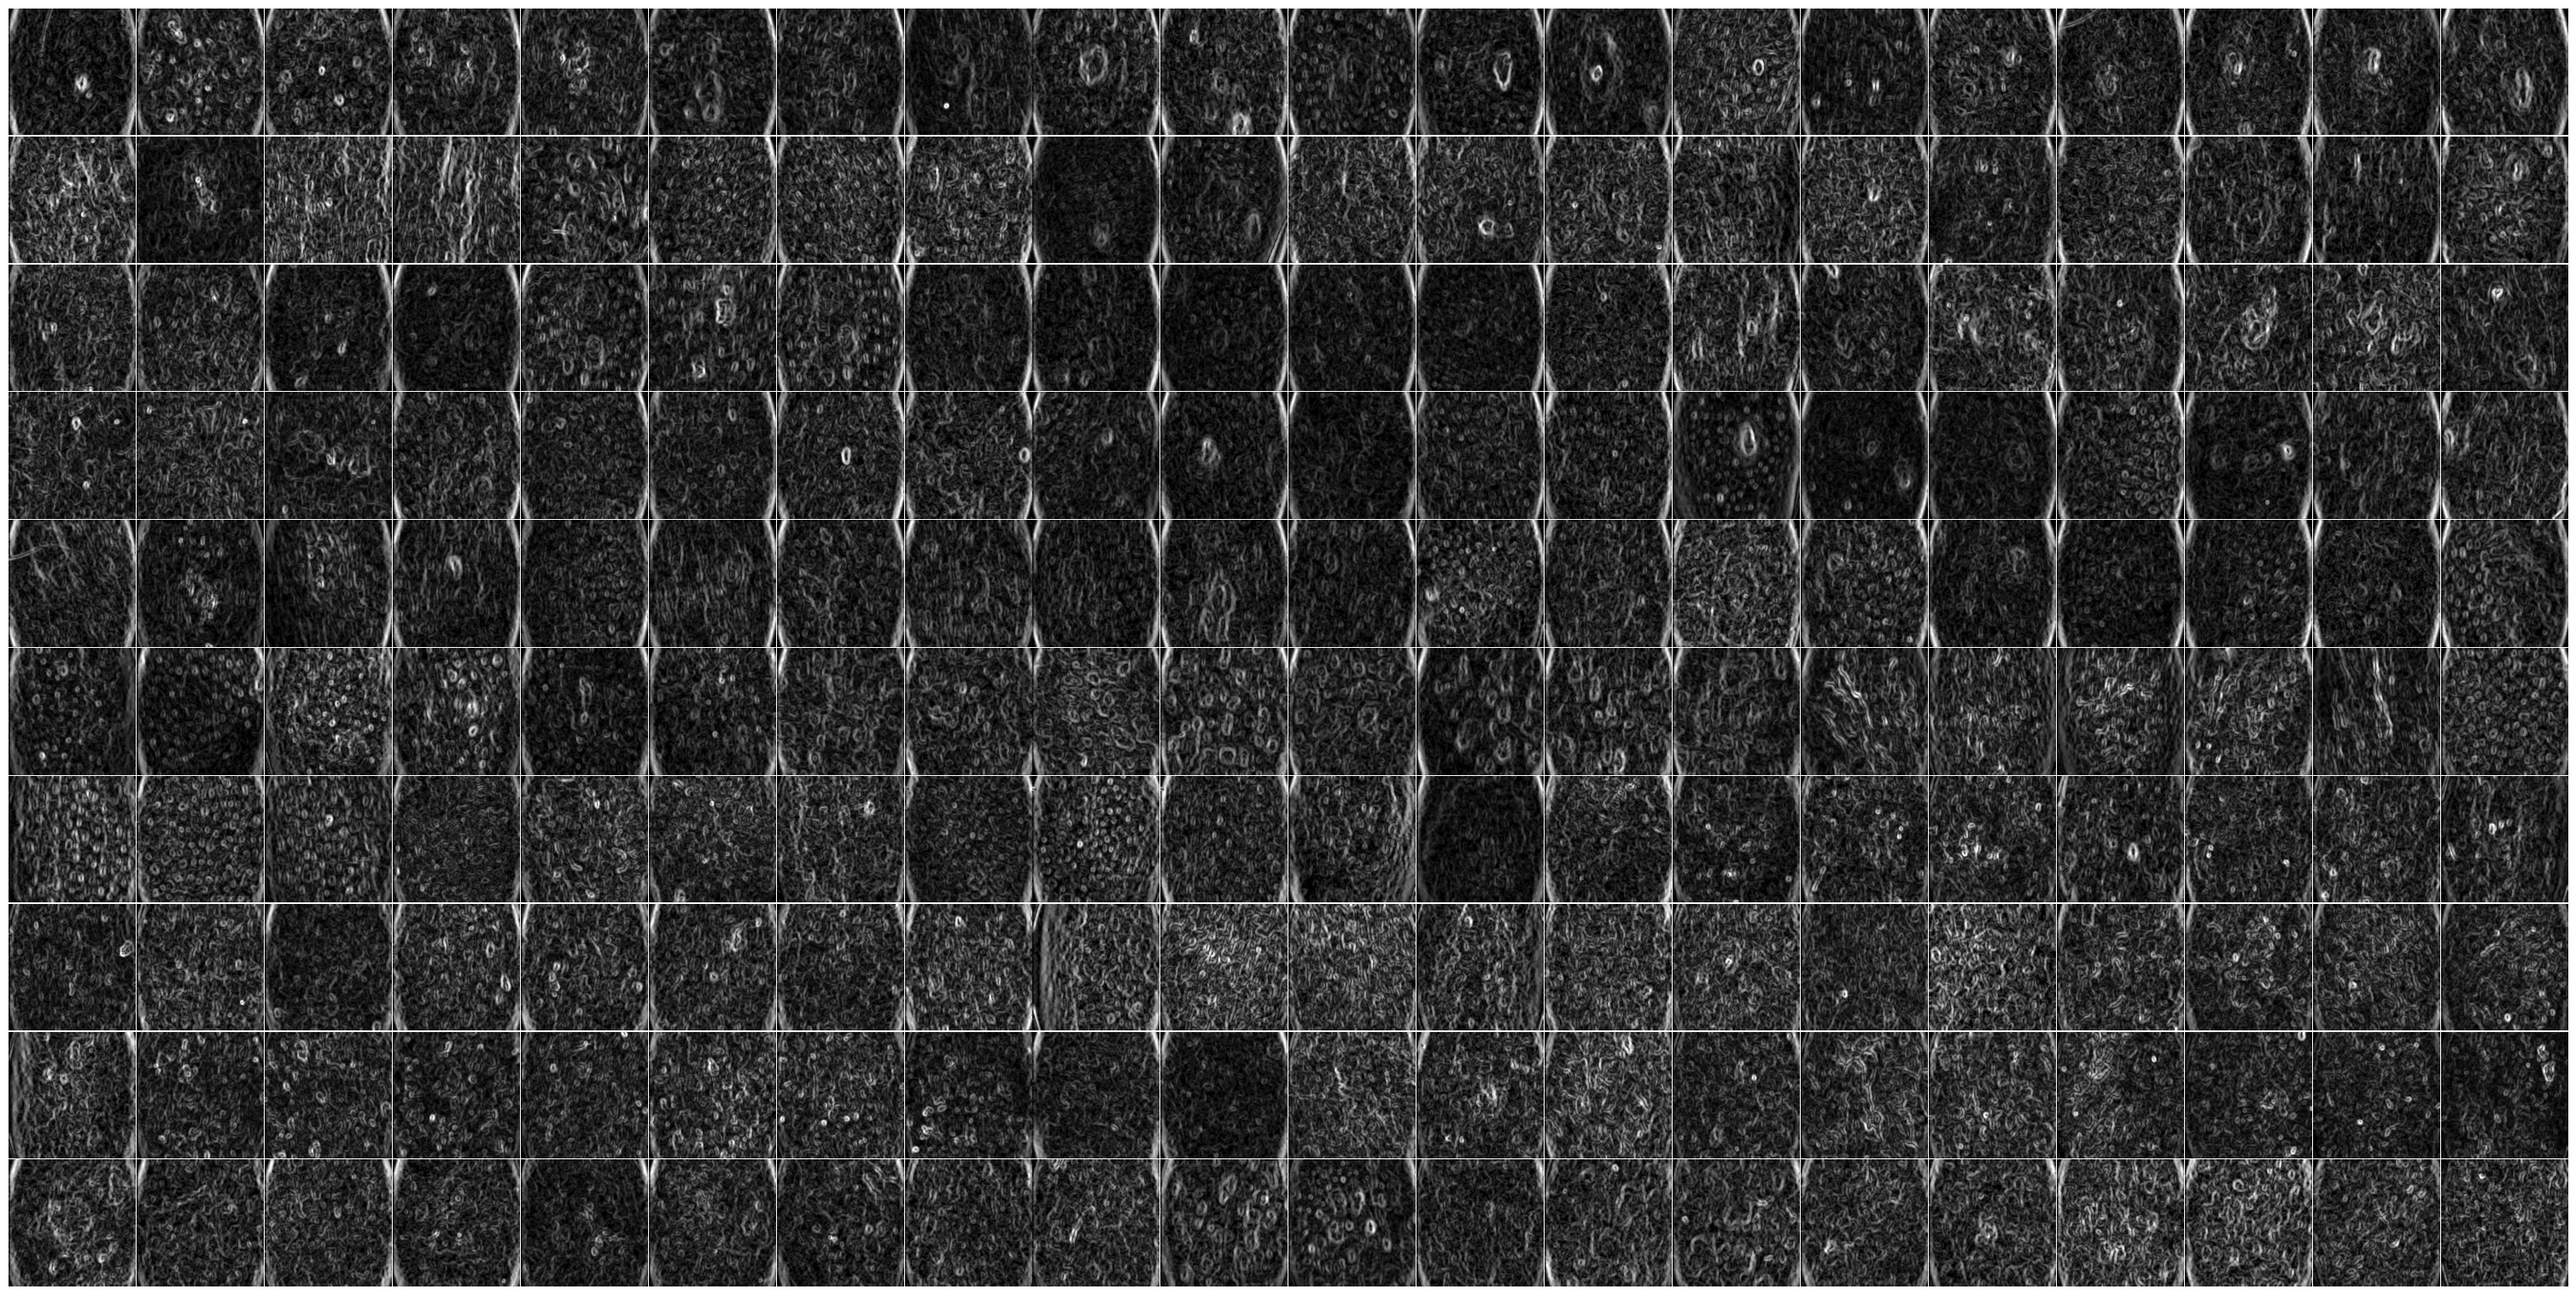

In [1440]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [1441]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [1442]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [1443]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [1444]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [1445]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [1446]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [1447]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [1448]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [1449]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [1450]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [1451]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [1452]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [1453]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [1454]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [1455]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [1456]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [1457]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [1458]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [1459]:
print(df.describe())  # Lihat ringkasan statistik fitur

        Contrast0  Contrast45  Contrast90  Contrast135  Homogeneity0  \
count  200.000000  200.000000  200.000000   200.000000    200.000000   
mean   215.156639  279.581918  105.084192   283.061643      0.479428   
std     84.532484  111.697738   45.317564   112.581963      0.031142   
min     75.935524   88.758585   30.365885   100.433664      0.409586   
25%    150.638676  194.829758   70.487129   197.079066      0.457242   
50%    200.591062  260.349673   98.508885   263.280354      0.478048   
75%    258.997315  346.756920  134.720684   341.730142      0.502146   
max    514.463251  723.772026  311.208471   707.116248      0.555310   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     200.000000     200.000000      200.000000      200.000000   
mean        0.330007       0.521076        0.329394        8.595879   
std         0.037853       0.039088        0.038027        1.809947   
min         0.247253       0.422393        0.245535        5.105407

<h1>CSV</h1>

In [1460]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_5.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_5.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  154.475720  215.170073   79.495466   
1    102_2.jpg  Acne Vulgaris  197.764491  254.006674  117.259865   
2    103_2.jpg  Acne Vulgaris  214.992877  303.017178  128.791896   
3    106_1.jpg  Acne Vulgaris  199.588404  251.580131   90.659176   
4    106_7.jpg  Acne Vulgaris  199.969516  264.905636   80.927482   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  257.991176  351.402537  147.631296   
196  118_3.jpg        Rosacea  452.979611  572.601968  212.252390   
197  118_4.jpg        Rosacea  437.764813  612.742099  229.414553   
198  119_1.jpg        Rosacea  267.331020  408.659731  174.824954   
199  119_2.jpg        Rosacea  338.769301  480.650642  210.852604   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     188.605721      0.535861       0.392266       0.584954        0.402598   
1     302.375194      0.442132       0.290728       0.479720        0.287617   
2     294.248766      0.505242       0.346441       0.532908        0.352962   
3     257.970012      0.481932       0.335088       0.527945        0.331700   
4     234.611119      0.449052       0.297603       0.497203        0.301954   
..           ...           ...            ...            ...             ...   
195   357.477924      0.477729       0.328178       0.515981        0.322811   
196   604.611580      0.436400       0.279572       0.471831        0.280624   
197   558.408443      0.469234       0.316545       0.505233        0.317852   
198   347.201200      0.463451       0.291742       0.476335        0.299589   
199   474.716278      0.471227       0.301965       0.489223        0.301997   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.049503  0.031349  0.206177  0.173498  0.222492   0.177057   
1    ...  0.020459  0.011336  0.131426  0.108009  0.143035   0.106468   
2    ...  0.036567  0.022555  0.181421  0.148607  0.191225   0.150184   
3    ...  0.031259  0.018064  0.161879  0.135247  0.176802   0.134401   
4    ...  0.025298  0.013867  0.141404  0.116073  0.159055   0.117760   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.031908  0.018305  0.165028  0.136767  0.178628   0.135298   
196  ...  0.020372  0.010975  0.130214  0.104896  0.142731   0.104763   
197  ...  0.029087  0.016867  0.157350  0.129084  0.170550   0.129873   
198  ...  0.023500  0.013840  0.146610  0.115255  0.153298   0.117642   
199  ...  0.026951  0.015313  0.156018  0.123732  0.164169   0.123746   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.941184       0.917994       0.969815        0.928119  
1        0.924867       0.903495       0.955540        0.885119  
2        0.912579       0.876556       0.947586        0.880129  
3        0.919008       0.897766       0.963468        0.895169  
4        0.886888       0.850017       0.954327        0.867170  
..            ...            ...            ...             ...  
195      0.899138       0.862449       0.942332        0.860070  
196      0.872646       0.838907       0.940401        0.829900  
197      0.883366       0.836392       0.938778        0.850900  
198      0.864597       0.792712       0.911426        0.823883  
199      0.839246       0.771834       0.899994        0.774648  

[200 rows x 30 columns]

<Axes: >

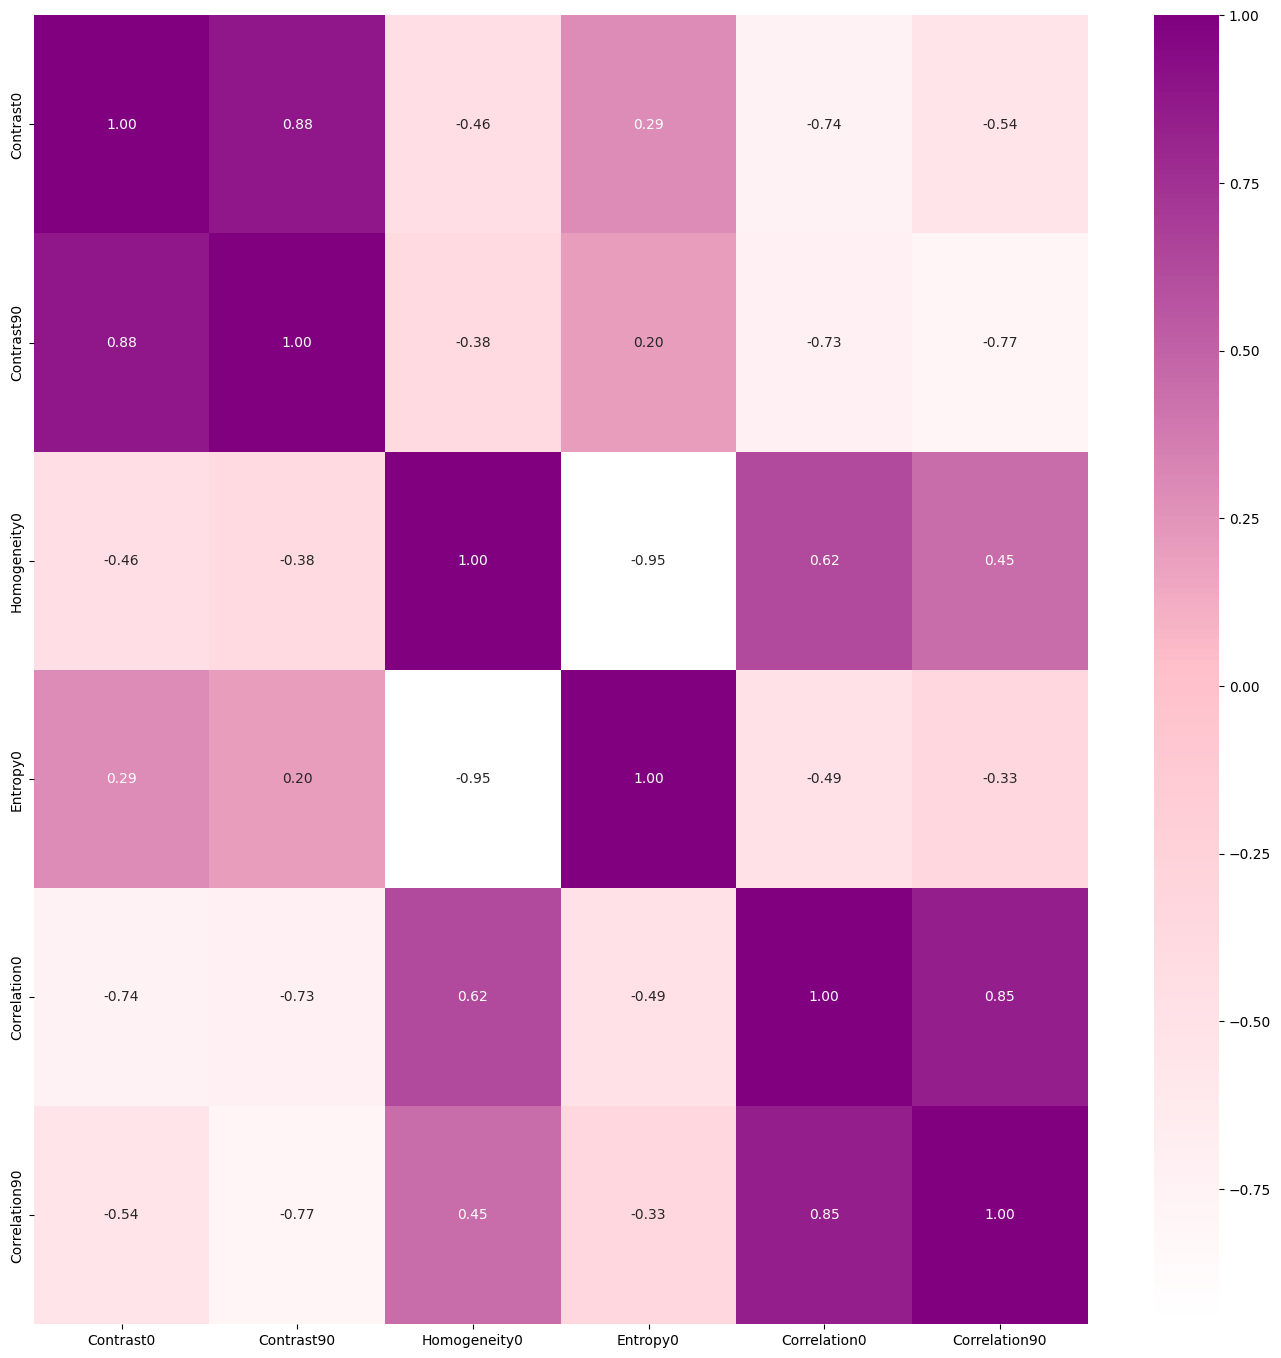

In [1461]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [1462]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [1463]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [1509]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=7, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)

In [1485]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------RANDOM FOREST------")
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------RANDOM FOREST------
------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.99      0.97      0.98        69
      Rosacea       0.97      0.99      0.98        71

     accuracy                           0.98       140
    macro avg       0.98      0.98      0.98       140
 weighted avg       0.98      0.98      0.98       140

[[67  2]
 [ 1 70]]
Accuracy: 0.9785714285714285

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.88      0.94      0.91        31
      Rosacea       0.93      0.86      0.89        29

     accuracy                           0.90        60
    macro avg       0.90      0.90      0.90        60
 weighted avg       0.90      0.90      0.90        60

[[29  2]
 [ 4 25]]
Accuracy: 0.9


In [1510]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------SVM------")
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

------SVM------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.70      0.74        69
      Rosacea       0.74      0.83      0.78        71

     accuracy                           0.76       140
    macro avg       0.77      0.76      0.76       140
 weighted avg       0.77      0.76      0.76       140

[[48 21]
 [12 59]]
Accuracy: 0.7642857142857142

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.90      0.87      0.89        31
      Rosacea       0.87      0.90      0.88        29

     accuracy                           0.88        60
    macro avg       0.88      0.88      0.88        60
 weighted avg       0.88      0.88      0.88        60

[[27  4]
 [ 3 26]]
Accuracy: 0.8833333333333333


In [1491]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------KNN------")
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

------KNN------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.74      0.83      0.78        69
      Rosacea       0.81      0.72      0.76        71

     accuracy                           0.77       140
    macro avg       0.77      0.77      0.77       140
 weighted avg       0.78      0.77      0.77       140

[[57 12]
 [20 51]]
Accuracy: 0.7714285714285715

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.82      0.87      0.84        31
      Rosacea       0.85      0.79      0.82        29

     accuracy                           0.83        60
    macro avg       0.84      0.83      0.83        60
 weighted avg       0.83      0.83      0.83        60

[[27  4]
 [ 6 23]]
Accuracy: 0.8333333333333334


In [1468]:
print("\n------Train Set RF------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set SVM------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set KNN------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)


------Train Set RF------
               precision    recall  f1-score   support

Acne Vulgaris       1.00      0.99      0.99        69
      Rosacea       0.99      1.00      0.99        71

     accuracy                           0.99       140
    macro avg       0.99      0.99      0.99       140
 weighted avg       0.99      0.99      0.99       140

[[68  1]
 [ 0 71]]
Accuracy: 0.9928571428571429

------Train Set SVM------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.70      0.74        69
      Rosacea       0.74      0.83      0.78        71

     accuracy                           0.76       140
    macro avg       0.77      0.76      0.76       140
 weighted avg       0.77      0.76      0.76       140

[[48 21]
 [12 59]]
Accuracy: 0.7642857142857142

------Train Set KNN------
               precision    recall  f1-score   support

Acne Vulgaris       0.79      0.77      0.78        69
      Rosacea       0.78      0.80      0.79   

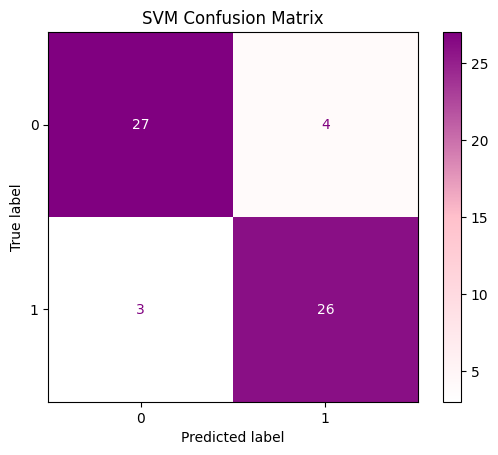

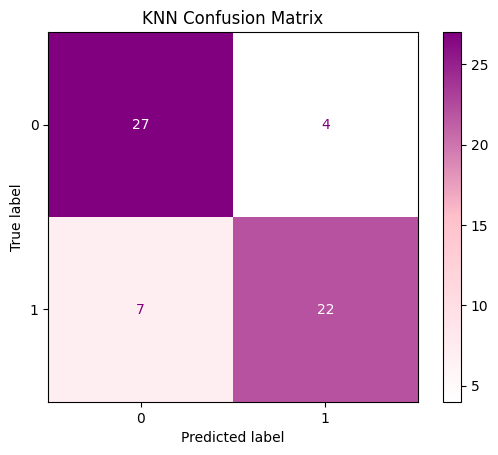

In [1469]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")